In [1]:
!pip install -q kaggle
# upload kaggle api .json file to download dataset
from google.colab import files
files.upload()
# make a directory in file system used to store the Kaggle API token, which is required to authenticate with the Kaggle platform and interact with the Kaggle API.
!mkdir -p ~/.kaggle
# copy .json file into new directory
!cp kaggle.json ~/.kaggle/
# Give permission to use .json file for read and write to root user
!chmod 600 /root/.kaggle/kaggle.json
# download dataset from kaggle
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
# unzip dowloaded dataset
!unzip /content/stanford-dogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

### Load Libraries and Data

In [2]:
import os
import matplotlib.pyplot as plt
import cv2, glob
from pathlib import Path
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
dog_images = glob.glob('/content/images/Images/*/*')
directory_path = '/content/images/Images/'
annotations = glob.glob('/content/annotations/Annotation/*/*')
cropped = "/content/Cropped/"

In [4]:
items = os.listdir(directory_path)
folder_names = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
folder_names

['n02093859-Kerry_blue_terrier',
 'n02104029-kuvasz',
 'n02094114-Norfolk_terrier',
 'n02085782-Japanese_spaniel',
 'n02112137-chow',
 'n02097474-Tibetan_terrier',
 'n02091134-whippet',
 'n02105162-malinois',
 'n02105855-Shetland_sheepdog',
 'n02106166-Border_collie',
 'n02113712-miniature_poodle',
 'n02100735-English_setter',
 'n02097047-miniature_schnauzer',
 'n02099849-Chesapeake_Bay_retriever',
 'n02093754-Border_terrier',
 'n02102177-Welsh_springer_spaniel',
 'n02093428-American_Staffordshire_terrier',
 'n02092002-Scottish_deerhound',
 'n02110806-basenji',
 'n02109525-Saint_Bernard',
 'n02109961-Eskimo_dog',
 'n02086079-Pekinese',
 'n02090622-borzoi',
 'n02095889-Sealyham_terrier',
 'n02095314-wire-haired_fox_terrier',
 'n02107574-Greater_Swiss_Mountain_dog',
 'n02099429-curly-coated_retriever',
 'n02109047-Great_Dane',
 'n02088094-Afghan_hound',
 'n02113978-Mexican_hairless',
 'n02091467-Norwegian_elkhound',
 'n02095570-Lakeland_terrier',
 'n02099712-Labrador_retriever',
 'n02089

In [5]:
breed1 = 'n02102177-Welsh_springer_spaniel'
breed2 = 'n02111129-Leonberg'
breed3 = 'n02107683-Bernese_mountain_dog'
breed4 = 'n02093991-Irish_terrier'
class_1 = glob.glob(directory_path + breed1 + '/*.jpg')
class_2 = glob.glob(directory_path + breed2 + '/*.jpg')
class_3 = glob.glob(directory_path + breed3 + '/*.jpg')
class_4 = glob.glob(directory_path + breed4 + '/*.jpg')

## (a) Cropping and Resize Images in Your 4-class Images Dataset

In [6]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

#Get image path from annotation path
def get_image(annot):
    file = annot.split('/')
    img_filename = directory_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

# Filter dog_images and annotations for the specified breeds
filtered_dog_images = []
filtered_annotations = []

for dog_image, annotation in zip(dog_images, annotations):
    folder_name = annotation.split('/')[-2]
    if folder_name in [breed1, breed2, breed3, breed4]:
        filtered_annotations.append(annotation)
        filtered_dog_images.append(get_image(annotation))

print(len(filtered_dog_images), len(filtered_annotations))

747 747


In [7]:
img_size = 299
Path(cropped).mkdir(parents=True, exist_ok=True)
for i in range(len(filtered_dog_images)):
    annotation = filtered_annotations[i]
    folder_name = annotation.split('/')[-2]

    # Check if the folder_name is one of the specified breeds
    if folder_name in [breed1, breed2, breed3, breed4]:
        bbox = get_bounding_boxes(annotation)
        dog = filtered_dog_images[i]
        im = Image.open(dog)
        for j in range(len(bbox)):
            im2 = im.crop(bbox[j])
            im2 = im2.resize((img_size, img_size), Image.ANTIALIAS)
            new_path = dog.replace(directory_path, cropped)
            new_path = new_path.replace('.jpg', '-' + str(j) + '.jpg')
            im2 = im2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            im2.save(new_path)

<ipython-input-7-a290c898b1bd>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im2 = im2.resize((img_size, img_size), Image.ANTIALIAS)


## (b) Histogram Equalization (Image Intensity Normalization)

In [8]:
selected_image_paths = class_1[:2] + class_2[:2] + class_3[:2] + class_4[:2]
print(selected_image_paths)

['/content/images/Images/n02102177-Welsh_springer_spaniel/n02102177_716.jpg', '/content/images/Images/n02102177-Welsh_springer_spaniel/n02102177_528.jpg', '/content/images/Images/n02111129-Leonberg/n02111129_4618.jpg', '/content/images/Images/n02111129-Leonberg/n02111129_324.jpg', '/content/images/Images/n02107683-Bernese_mountain_dog/n02107683_34.jpg', '/content/images/Images/n02107683-Bernese_mountain_dog/n02107683_4386.jpg', '/content/images/Images/n02093991-Irish_terrier/n02093991_3807.jpg', '/content/images/Images/n02093991-Irish_terrier/n02093991_5001.jpg']


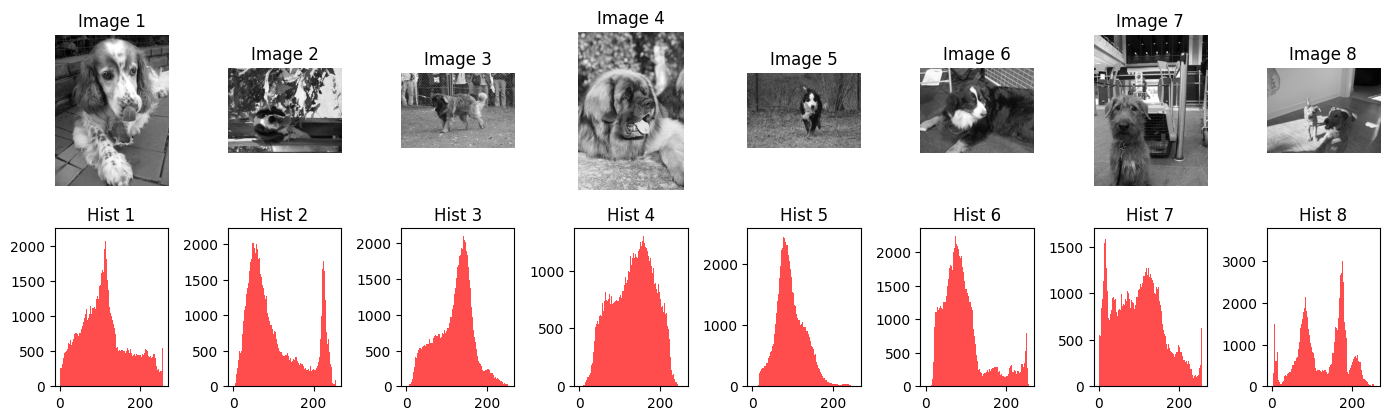

In [9]:
# Convert color images to grayscale and plot them with histograms
gray_images = []
plt.figure(figsize=(14, 8))
for i, image_path in enumerate(selected_image_paths):
    color_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_image)
    plt.subplot(4, 8, i + 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')
    plt.subplot(4, 8, i + 9)
    plt.hist(gray_image.flatten(), bins=256, range=(0, 256), color='r', alpha=0.7)
    plt.title(f'Hist {i + 1}')

plt.tight_layout()
plt.show()

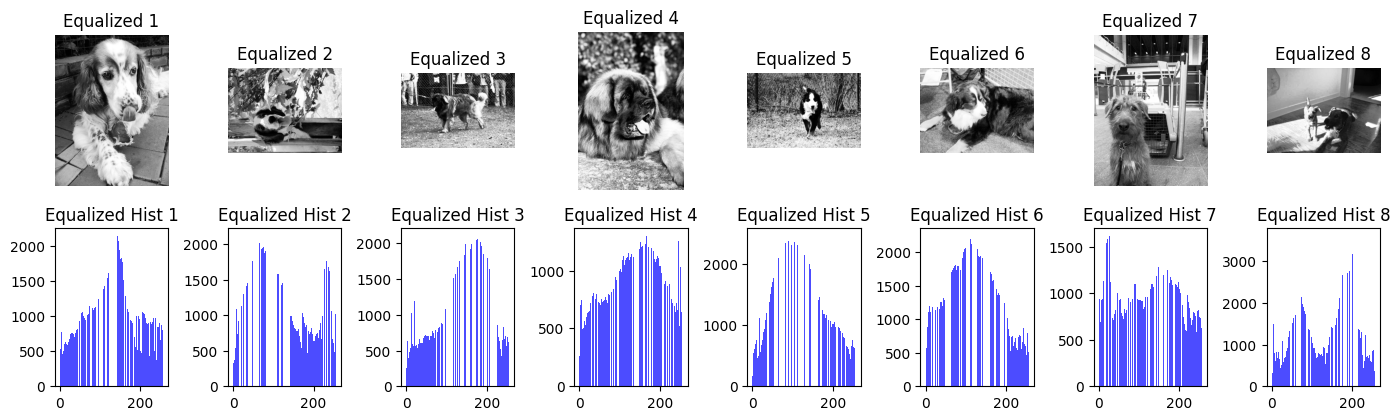

In [10]:
# Perform histogram equalization and plot the results
equalized_images = []
plt.figure(figsize=(14, 8))
for i, gray_image in enumerate(gray_images):
    equalized_image = cv2.equalizeHist(gray_image)
    equalized_images.append(equalized_image)
    plt.subplot(4, 8, i + 1)
    plt.imshow(equalized_image, cmap='gray')
    plt.title(f'Equalized {i + 1}')
    plt.axis('off')
    plt.subplot(4, 8, i + 9)
    plt.hist(equalized_image.flatten(), bins=256, range=(0, 256), color='b', alpha=0.7)
    plt.title(f'Equalized Hist {i + 1}')

plt.tight_layout()
plt.show()

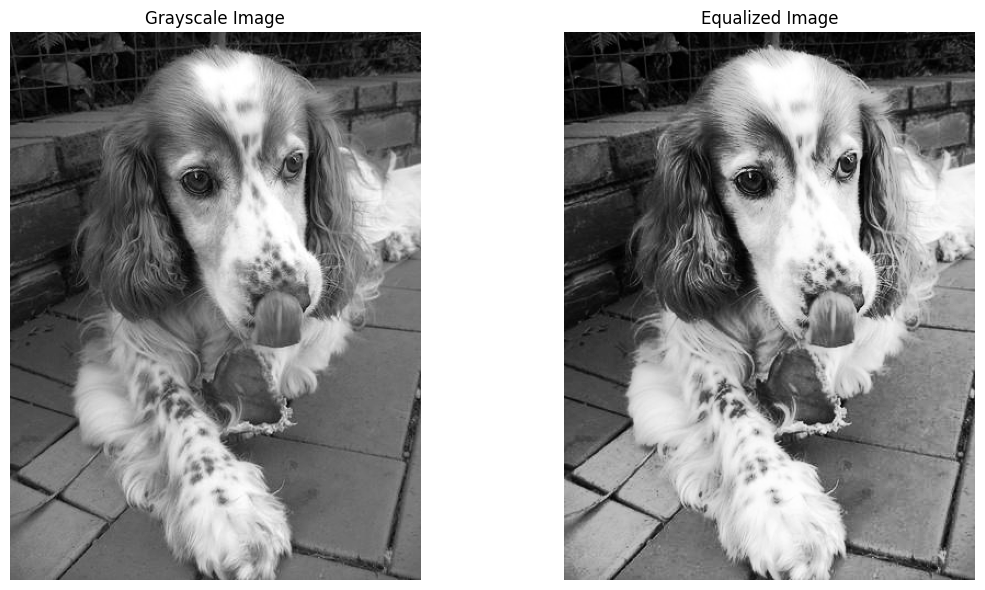

In [11]:
# Pick one grayscale image and its corresponding equalized image for observation
selected_index = 0
selected_gray_image = gray_images[selected_index]
selected_equalized_image = equalized_images[selected_index]
plt.figure(figsize=(12, 6))

# Plot the original and equalized images side by side
plt.subplot(1, 2, 1)
plt.imshow(selected_gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(selected_equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')
plt.tight_layout()
plt.show()

## (c) RGB histogram

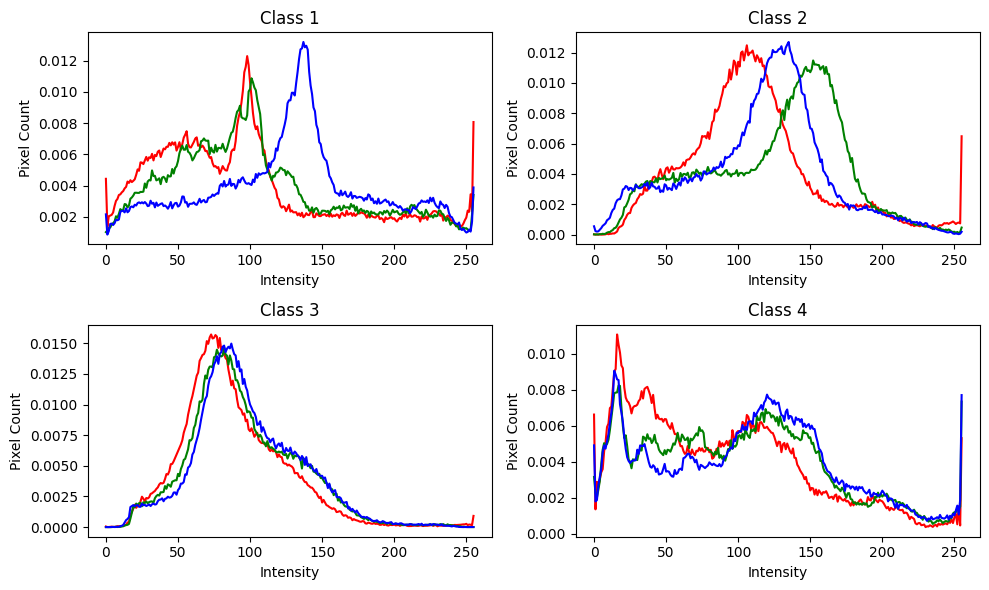

In [12]:
# Load and preprocess the images
images = [class_1[0], class_2[0], class_3[0], class_4[0]]
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(10, 6))
for i, image_path in enumerate(images):
    image = cv2.imread(image_path)
    r, g, b = cv2.split(image)
    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()
    plt.subplot(2, 2, i + 1)
    plt.plot(hist_r, color='red')
    plt.plot(hist_g, color='green')
    plt.plot(hist_b, color='blue')
    plt.title(labels[i])
    plt.xlabel('Intensity')
    plt.ylabel('Pixel Count')

plt.tight_layout()
plt.show()

## (d) Histogram Comparison (Measures of Similarity and Dissimilarity)

In [13]:
# Define distance functions
def euclidean_distance(hist1, hist2):
    return np.linalg.norm(hist1 - hist2)

def manhattan_distance(hist1, hist2):
    return np.sum(np.abs(hist1 - hist2))

def bhattacharyya_distance(hist1, hist2):
    return -np.log(np.sum(np.sqrt(hist1 * hist2)))

def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))

In [14]:
images = [cv2.imread(image) for image in class_1[:2] + [class_2[0]]]
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
histograms = [cv2.calcHist([gray], [0], None, [256], [0, 256]) / np.sum(gray) for gray in gray_images]
distances = {
    'euclidean': euclidean_distance(histograms[0], histograms[1]),
    'manhattan': manhattan_distance(histograms[0], histograms[1]),
    'bhattacharyya': bhattacharyya_distance(histograms[0], histograms[1]),
    'hist_intersection': histogram_intersection(histograms[0], histograms[1]),
}
print("Distances for same class images:")
for measure, distance in distances.items():
    print(f"{measure.capitalize()} Distance:", distance)
distances = {
    'euclidean': euclidean_distance(histograms[0], histograms[2]),
    'manhattan': manhattan_distance(histograms[0], histograms[2]),
    'bhattacharyya': bhattacharyya_distance(histograms[0], histograms[2]),
    'hist_intersection': histogram_intersection(histograms[0], histograms[2]),
}
print("\nDistances for different class images:")
for measure, distance in distances.items():
    print(f"{measure.capitalize()} Distance:", distance)

Distances for same class images:
Euclidean Distance: 0.00048515177308794296
Manhattan Distance: 0.0057572661949441585
Bhattacharyya Distance: 4.745298306503388
Hist_intersection Distance: 0.006430131457674283

Distances for different class images:
Euclidean Distance: 0.0004450846470230423
Manhattan Distance: 0.005365831067788747
Bhattacharyya Distance: 4.8322473536882935
Hist_intersection Distance: 0.005932129910390532


## (e) Image Feature Descriptor: ORB (Oriented FAST and Rotated BRIEF)

Number of keypoints extracted: 30
Edge threshold value: 40
Patch size value: 25


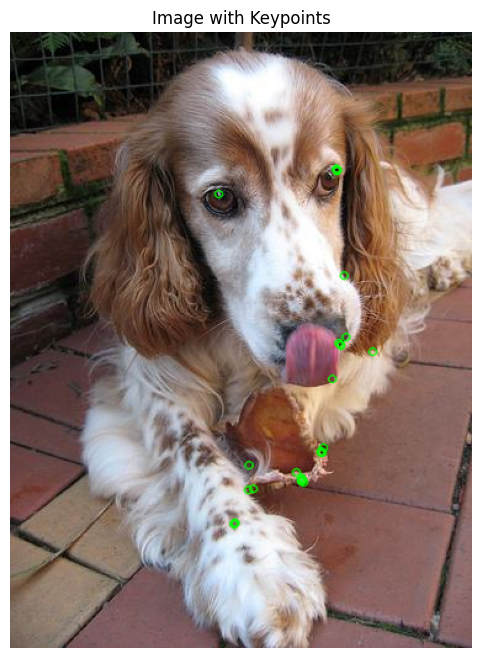

Number of keypoints extracted: 30
Edge threshold value: 35
Patch size value: 45


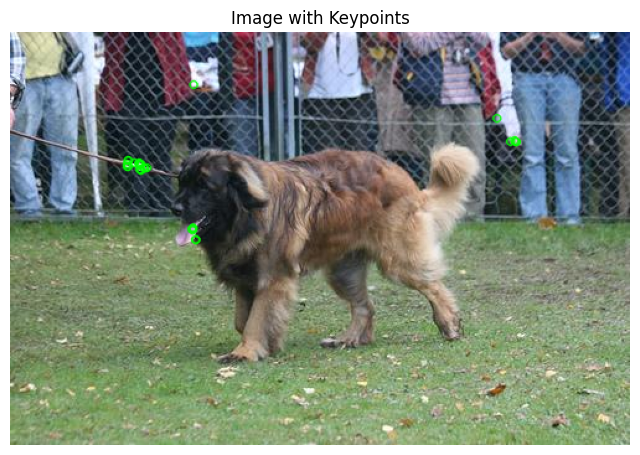

Number of keypoints extracted: 30
Edge threshold value: 45
Patch size value: 65


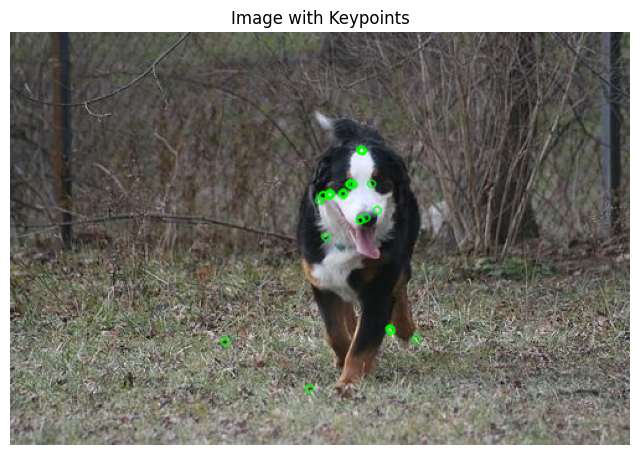

Number of keypoints extracted: 29
Edge threshold value: 60
Patch size value: 75


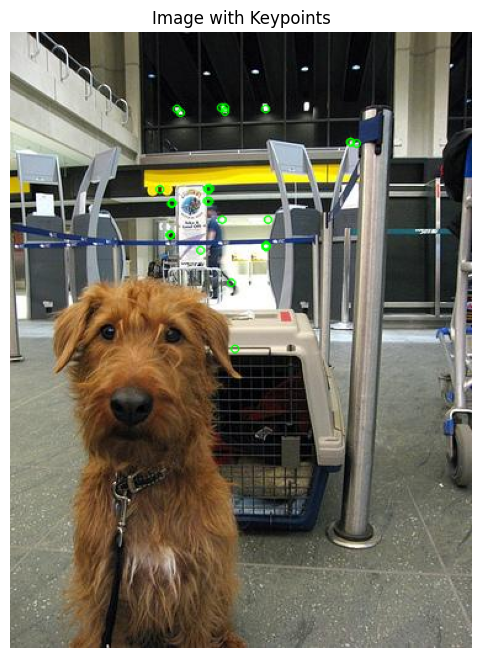

In [15]:
def extract_and_visualize_keypoints(image_path, edge_threshold, patch_size):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    orb = cv2.ORB_create(
        edgeThreshold=edge_threshold,
        patchSize=patch_size,
        nlevels=8,
        fastThreshold=20,
        scaleFactor=1.2,
        WTA_K=2,
        scoreType=cv2.ORB_HARRIS_SCORE,
        firstLevel=0,
        nfeatures=30
    )
    kp = orb.detect(img, None)
    num_keypoints = len(kp)
    print("Number of keypoints extracted:", num_keypoints)
    print("Edge threshold value:", edge_threshold)
    print("Patch size value:", patch_size)
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0))
    img_with_keypoints_rgb = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_with_keypoints_rgb)
    plt.axis('off')
    plt.title("Image with Keypoints")
    plt.show()

extract_and_visualize_keypoints(class_1[0], edge_threshold=40, patch_size=25)
extract_and_visualize_keypoints(class_2[0], edge_threshold=35, patch_size=45)
extract_and_visualize_keypoints(class_3[0], edge_threshold=45, patch_size=65)
extract_and_visualize_keypoints(class_4[0], edge_threshold=60, patch_size=75)

## (f) Dimensionality reduction (using PrincipalComponent Analysis, PCA)

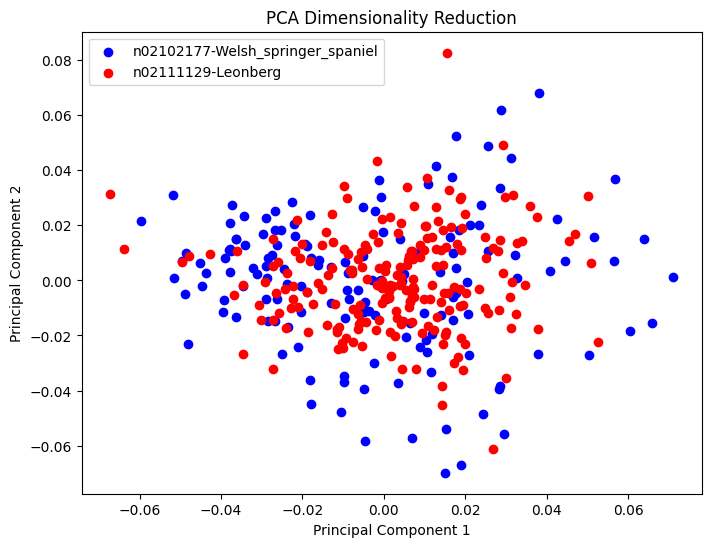

In [16]:
histograms = []
for image_path in class_1 + class_2:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_normalized = hist / np.sum(hist)
    histograms.append(hist_normalized.flatten())

histograms = np.array(histograms)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(histograms)
pca_breed1 = pca_result[:len(class_1)]
pca_breed2 = pca_result[len(class_1):]

plt.figure(figsize=(8, 6))
plt.scatter(pca_breed1[:, 0], pca_breed1[:, 1], c='b', label=breed1)
plt.scatter(pca_breed2[:, 0], pca_breed2[:, 1], c='r', label=breed2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Dimensionality Reduction')
plt.legend()
plt.show()